In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm_joblib import tqdm_joblib
from tqdm.auto import tqdm
import re

/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def compute_correlations(file, folder):
    file_path = os.path.join(folder, file)
    simulation = pd.read_csv(file_path)
    t1_data = simulation[simulation['timestep'] == t1]
    t2_data = simulation[simulation['timestep'] == t2]
    
    t1_corr = spearmanr(t1_data['gene_1_total_mRNA'], t1_data['gene_2_total_mRNA']).correlation
    t2_corr = spearmanr(t2_data['gene_1_total_mRNA'], t2_data['gene_2_total_mRNA']).correlation
    
    match = re.search(r"rAdd_(\d+\.\d+)", file)
    r_add = float(match.group(1))
    return {
        "r_add": r_add,
        t1: t1_corr,
        t2: t2_corr
    }

# Modify k_on: r_add is subtracted


In [3]:
folder_simulations_k_on = "/home/mzo5929/Keerthana/grnInference/simulationData/general_simulation_data/r_add_k_on_repression/"
list_files = os.listdir(folder_simulations_k_on)
file_list_2 = [file for file in list_files if ("n_2" in file) and ("k_on_B" not in file)]
file_list_4 = [file for file in list_files if "n_4" in file]
file_list_max_k_on = [file for file in list_files if ("n_2" in file) and ("max_k_on_B" in file)]
file_list_min_k_on = [file for file in list_files if ("n_2" in file) and ("min_k_on_B" in file)]

t1 = 300
t2 = 600



# Set number of workers
n_jobs = 8  # Use all cores, or set to a fixed number like 8

# Run in parallel
results_2 = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_on) for file in tqdm(file_list_2)
)
results_4 = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_on) for file in tqdm(file_list_4)
)

results_max_k_on = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_on) for file in tqdm(file_list_max_k_on)
)

results_min_k_on = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_on) for file in tqdm(file_list_min_k_on)
)

# Convert to DataFrame
corr_index_k_on_2 = pd.DataFrame(results_2)
corr_index_k_on_2['n'] =2
corr_index_k_on_4 = pd.DataFrame(results_4)
corr_index_k_on_4['n'] =4
corr_index_max_k_on = pd.DataFrame(results_max_k_on)
corr_index_max_k_on['n'] =2
corr_index_min_k_on = pd.DataFrame(results_min_k_on)
corr_index_min_k_on['n'] =2




  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

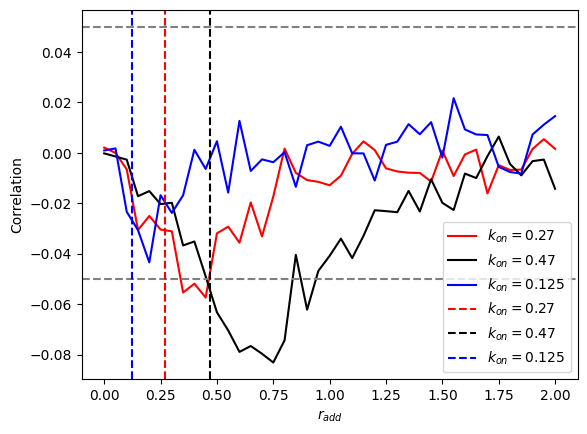

In [6]:
corr_index_k_on_2 = corr_index_k_on_2.sort_values(by="r_add")
corr_index_k_on_4 = corr_index_k_on_4.sort_values(by="r_add")
corr_index_max_k_on = corr_index_max_k_on.sort_values(by="r_add")
corr_index_min_k_on = corr_index_min_k_on.sort_values(by="r_add")

plt.plot(corr_index_k_on_2['r_add'], corr_index_k_on_2[300], label = "$k_{on} = 0.27$", color = "red")
# plt.plot(corr_index_k_on_4['r_add'], corr_index_k_on_4[300],  label = "n = 4")
plt.plot(corr_index_max_k_on['r_add'], corr_index_max_k_on[300],  label = r"$k_{on} = 0.47$", color = "black")
plt.plot(corr_index_min_k_on['r_add'], corr_index_min_k_on[300],  label = r"$k_{on} = 0.125$", color = "blue")

plt.axhline(0.05, linestyle = "--", color = "grey")
plt.axhline(-0.05, linestyle = "--", color = "grey")
plt.axvline(0.27, linestyle = "--", color = "red", label = r"$k_{on} = 0.27$")
plt.axvline(0.47, linestyle = "--", color = "black", label = r"$k_{on} = 0.47$")
plt.axvline(0.125, linestyle = "--", color = "blue", label = r"$k_{on} = 0.125$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Correlation")
plt.legend()
plt.show()

In [11]:
def get_average_level(file, folder_path, quantity_to_measure):
    file_path = os.path.join(folder_path, file)
    simulation = pd.read_csv(file_path)
    t1 = 300
    t1_data = simulation[simulation['timestep'] == t1]
    match = re.search(r"rAdd_(\d+\.\d+)", file)
    r_add = float(match.group(1))
    if quantity_to_measure == "mRNA":
        gene_level = t1_data['gene_2_total_mRNA'].mean()
    elif quantity_to_measure == "protein":
        gene_level = t1_data['gene_2_protein'].mean()
    return {
        "gene_level": gene_level,
        "r_add" : r_add
    }


In [14]:
# #Plot average mRNA and protein levels as a function of rAdd
# folder_simulations_k_on = "/home/mzo5929/Keerthana/grnInference/simulationData/general_simulation_data/r_add_k_on_repression/"
# list_files = os.listdir(folder_simulations_k_on)
# file_list_2 = [file for file in list_files if ("n_2" in file) and ("k_on_B" not in file)]
# file_list_4 = [file for file in list_files if "n_4" in file]
# file_list_max_k_on = [file for file in list_files if ("n_2" in file) and ("max_k_on_B" in file)]
# file_list_min_k_on = [file for file in list_files if ("n_2" in file) and ("min_k_on_B" in file)]

# t1 = 300
# t2 = 600



# # Set number of workers
# n_jobs = 8  # Use all cores, or set to a fixed number like 8

# # Run in parallel
# results_2_mRNA = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on, "mRNA") for file in tqdm(file_list_2)
# )
# results_2_protein= Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on, "protein") for file in tqdm(file_list_2)
# )
# results_4_mRNA = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on, "mRNA") for file in tqdm(file_list_4)
# )
# results_4_protein= Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on, "protein") for file in tqdm(file_list_4)
# )

# results_max_k_on_mRNA = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on,  "mRNA") for file in tqdm(file_list_max_k_on)
# )
# results_max_k_on_protein = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on,  "protein") for file in tqdm(file_list_max_k_on)
# )

# results_min_k_on_mRNA = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on,  "mRNA") for file in tqdm(file_list_min_k_on)
# )

# results_min_k_on_protein = Parallel(n_jobs=n_jobs)(
#     delayed(get_average_level)(file, folder_simulations_k_on,  "protein") for file in tqdm(file_list_min_k_on)
# )

# Convert to DataFrame
gene_level_2_mRNA = pd.DataFrame(results_2_mRNA)
gene_level_2_mRNA['n'] =2
gene_level_2_mRNA.sort_values(by = "r_add", inplace = True)
gene_level_2_protein = pd.DataFrame(results_2_protein)
gene_level_2_protein['n'] =2
gene_level_2_protein.sort_values(by = "r_add", inplace = True)

gene_level_4_mRNA = pd.DataFrame(results_4_mRNA)
gene_level_4_mRNA['n'] =4
gene_level_4_mRNA.sort_values(by = "r_add", inplace = True)
gene_level_4_protein = pd.DataFrame(results_4_protein)
gene_level_4_protein['n'] =4
gene_level_4_protein.sort_values(by = "r_add", inplace = True)

gene_level_2_max_k_on_mRNA = pd.DataFrame(results_max_k_on_mRNA)
gene_level_2_max_k_on_mRNA['n'] =2
gene_level_2_max_k_on_mRNA.sort_values(by = "r_add", inplace = True)
gene_level_2_max_k_on_protein = pd.DataFrame(results_max_k_on_protein)
gene_level_2_max_k_on_protein['n'] =2
gene_level_2_max_k_on_protein.sort_values(by = "r_add", inplace = True)

gene_level_2_min_k_on_mRNA = pd.DataFrame(results_min_k_on_mRNA)
gene_level_2_min_k_on_mRNA['n'] =2
gene_level_2_min_k_on_mRNA.sort_values(by = "r_add", inplace = True)
gene_level_2_min_k_on_protein = pd.DataFrame(results_min_k_on_protein)
gene_level_2_min_k_on_protein['n'] =2
gene_level_2_min_k_on_protein.sort_values(by = "r_add", inplace = True)







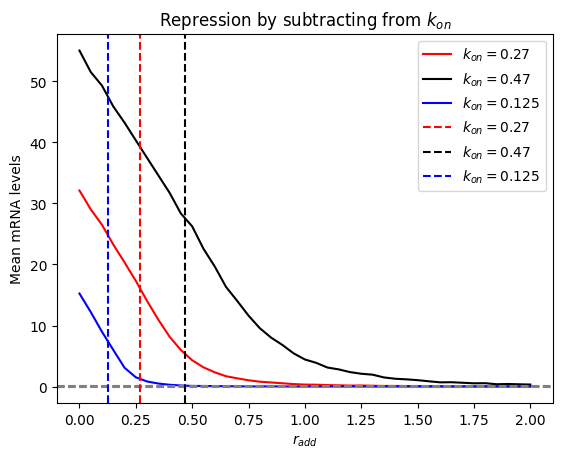

In [31]:
#Plotting mRNA levels vs r_add

plt.plot(gene_level_2_mRNA['r_add'], gene_level_2_mRNA["gene_level"], label = "$k_{on} = 0.27$", color = "red")
# plt.plot(gene_level_4_mRNA['r_add'], gene_level_4_mRNA["gene_level"],  label = "n = 4")
plt.plot(gene_level_2_max_k_on_mRNA['r_add'], gene_level_2_max_k_on_mRNA["gene_level"],  label = r"$k_{on} = 0.47$", color = "black")
plt.plot(gene_level_2_min_k_on_mRNA['r_add'], gene_level_2_min_k_on_mRNA["gene_level"],  label = r"$k_{on} = 0.125$", color = "blue")

plt.axhline(0.05, linestyle = "--", color = "grey")
plt.axhline(-0.05, linestyle = "--", color = "grey")
plt.axvline(0.27, linestyle = "--", color = "red", label = r"$k_{on} = 0.27$")
plt.axvline(0.47, linestyle = "--", color = "black", label = r"$k_{on} = 0.47$")
plt.axvline(0.125, linestyle = "--", color = "blue", label = r"$k_{on} = 0.125$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Mean mRNA levels")
plt.title(r"Repression by subtracting from $k_{on}$")
plt.legend()
plt.show()

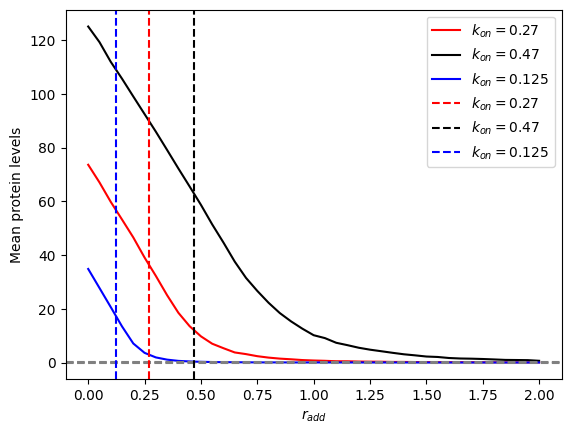

In [28]:
#Plotting mRNA levels vs r_add

plt.plot(gene_level_2_protein['r_add'], gene_level_2_protein["gene_level"], label = "$k_{on} = 0.27$", color = "red")
# plt.plot(gene_level_4_protein['r_add'], gene_level_4_mRNA["gene_level"],  label = "n = 4")
plt.plot(gene_level_2_max_k_on_protein['r_add'], gene_level_2_max_k_on_protein["gene_level"],  label = r"$k_{on} = 0.47$", color = "black")
plt.plot(gene_level_2_min_k_on_protein['r_add'], gene_level_2_min_k_on_protein["gene_level"],  label = r"$k_{on} = 0.125$", color = "blue")

plt.axhline(0.05, linestyle = "--", color = "grey")
plt.axhline(-0.05, linestyle = "--", color = "grey")
plt.axvline(0.27, linestyle = "--", color = "red", label = r"$k_{on} = 0.27$")
plt.axvline(0.47, linestyle = "--", color = "black", label = r"$k_{on} = 0.47$")
plt.axvline(0.125, linestyle = "--", color = "blue", label = r"$k_{on} = 0.125$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Mean protein levels")
plt.legend()
plt.show()

# Modify k_off: r_add is added


In [33]:
folder_simulations_k_off = "/home/mzo5929/Keerthana/grnInference/simulationData/general_simulation_data/r_add_k_off_repression/"

list_files = os.listdir(folder_simulations_k_off)
file_list_2 = [file for file in list_files if ("n_2" in file) and ("k_off" not in file)]
file_list_4 = [file for file in list_files if ("n_4" in file) and ("k_off" not in file)]

file_list_max_k_off = [file for file in list_files if ("n_2" in file) and ("max_k_off" in file)]
file_list_min_k_off = [file for file in list_files if ("n_2" in file) and ("min_k_off" in file)]

t1 = 300
t2 = 600



# Set number of workers
n_jobs = 8  # Use all cores, or set to a fixed number like 8

# Run in parallel
results_2 = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_off) for file in tqdm(file_list_2)
)
results_4 = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_off) for file in tqdm(file_list_4)
)


results_max_k_off = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_off) for file in tqdm(file_list_max_k_off)
)

results_min_k_off = Parallel(n_jobs=n_jobs)(
    delayed(compute_correlations)(file, folder_simulations_k_off) for file in tqdm(file_list_min_k_off)
)

# Convert to DataFrame
corr_index_k_off_2 = pd.DataFrame(results_2)
corr_index_k_off_2['n'] =2
corr_index_k_off_4 = pd.DataFrame(results_4)
corr_index_k_off_4['n'] =4
corr_index_max_k_off = pd.DataFrame(results_max_k_off)
corr_index_max_k_off['n'] =2
corr_index_min_k_off = pd.DataFrame(results_min_k_off)
corr_index_min_k_off['n'] =2





  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

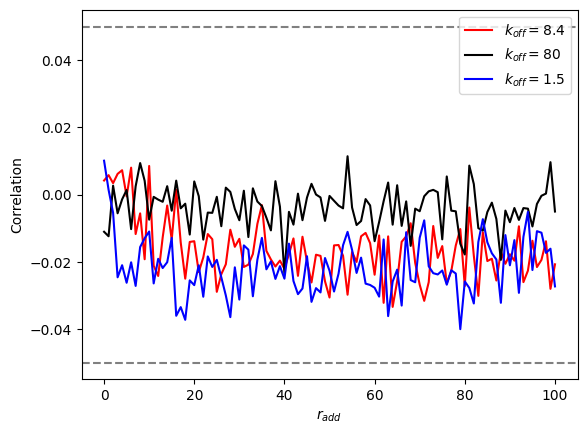

In [34]:
corr_index_k_off_2 = corr_index_k_off_2.sort_values(by="r_add")
corr_index_k_off_4 = corr_index_k_off_4.sort_values(by="r_add")
corr_index_max_k_off = corr_index_max_k_off.sort_values(by="r_add")
corr_index_min_k_off = corr_index_min_k_off.sort_values(by="r_add")

plt.plot(corr_index_k_off_2['r_add'], corr_index_k_off_2[300], label = r"$k_{off} = 8.4$", color = "red")
# plt.plot(corr_index_k_off_4['r_add'], corr_index_k_off_4[300],  label = "n = 4")
plt.plot(corr_index_max_k_off['r_add'], corr_index_max_k_off[300],  label = r"$k_{off} = 80$", color = "black")
plt.plot(corr_index_min_k_off['r_add'], corr_index_min_k_off[300],  label = r"$k_{off} = 1.5$", color = "blue")

plt.axhline(0.05, linestyle = "--", color = "grey")
plt.axhline(-0.05, linestyle = "--", color = "grey")
# plt.axvline(8.4, linestyle = "--", color = "red", label = r"$k_{off} = 8.4$")
# plt.axvline(80, linestyle = "--", color = "black", label = r"$k_{off} = 80$")
# plt.axvline(1.5, linestyle = "--", color = "blue", label = r"$k_{off} = 1.5$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Correlation")
plt.legend()
plt.show()

In [24]:
#Plot average mRNA and protein levels as a function of rAdd
folder_simulations_k_off = "/home/mzo5929/Keerthana/grnInference/simulationData/general_simulation_data/r_add_k_off_repression/"
list_files = os.listdir(folder_simulations_k_off)
file_list_2_kOff = [file for file in list_files if ("n_2" in file) and ("k_off" not in file)]
file_list_4_kOff = [file for file in list_files if ("n_4" in file) and ("k_off" not in file)]

file_list_max_k_off = [file for file in list_files if ("n_2" in file) and ("max_k_off" in file)]
file_list_min_k_off = [file for file in list_files if ("n_2" in file) and ("min_k_off" in file)]

t1 = 300
t2 = 600



# Set number of workers
n_jobs = 8  # Use all cores, or set to a fixed number like 8

# Run in parallel
results_2_mRNA_kOff = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off, "mRNA") for file in tqdm(file_list_2_kOff)
)
results_2_protein_kOff= Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off, "protein") for file in tqdm(file_list_2_kOff)
)
results_4_mRNA_kOff = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off, "mRNA") for file in tqdm(file_list_4_kOff)
)
results_4_protein_kOff= Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off, "protein") for file in tqdm(file_list_4_kOff)
)

results_max_k_off_mRNA = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off,  "mRNA") for file in tqdm(file_list_max_k_off)
)
results_max_k_off_protein = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off,  "protein") for file in tqdm(file_list_max_k_off)
)

results_min_k_off_mRNA = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off,  "mRNA") for file in tqdm(file_list_min_k_off)
)

results_min_k_off_protein = Parallel(n_jobs=n_jobs)(
    delayed(get_average_level)(file, folder_simulations_k_off,  "protein") for file in tqdm(file_list_min_k_off)
)


# Convert to DataFrame
gene_level_2_mRNA_kOff = pd.DataFrame(results_2_mRNA_kOff)
gene_level_2_mRNA_kOff['n'] =2
gene_level_2_mRNA_kOff.sort_values(by = "r_add", inplace = True)
gene_level_2_protein_kOff = pd.DataFrame(results_2_protein_kOff)
gene_level_2_protein_kOff['n'] =2
gene_level_2_protein_kOff.sort_values(by = "r_add", inplace = True)

gene_level_4_mRNA_kOff = pd.DataFrame(results_4_mRNA_kOff)
gene_level_4_mRNA_kOff['n'] =4
gene_level_4_mRNA_kOff.sort_values(by = "r_add", inplace = True)
gene_level_4_protein_kOff = pd.DataFrame(results_4_protein_kOff)
gene_level_4_protein_kOff['n'] =4
gene_level_4_protein_kOff.sort_values(by = "r_add", inplace = True)

gene_level_2_max_k_off_mRNA = pd.DataFrame(results_max_k_off_mRNA)
gene_level_2_max_k_off_mRNA['n'] =2
gene_level_2_max_k_off_mRNA.sort_values(by = "r_add", inplace = True)

gene_level_2_max_k_off_protein = pd.DataFrame(results_max_k_off_protein)
gene_level_2_max_k_off_protein['n'] =2
gene_level_2_max_k_off_protein.sort_values(by = "r_add", inplace = True)

gene_level_2_min_k_off_mRNA = pd.DataFrame(results_min_k_off_mRNA)
gene_level_2_min_k_off_mRNA['n'] =2
gene_level_2_min_k_off_mRNA.sort_values(by = "r_add", inplace = True)

gene_level_2_min_k_off_protein = pd.DataFrame(results_min_k_off_protein)
gene_level_2_min_k_off_protein['n'] =2
gene_level_2_min_k_off_protein.sort_values(by = "r_add", inplace = True)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

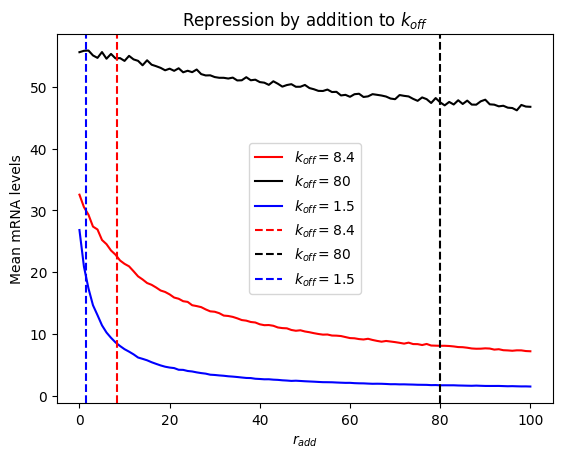

In [32]:
#Plotting mRNA levels vs r_add

plt.plot(gene_level_2_mRNA_kOff['r_add'], gene_level_2_mRNA_kOff["gene_level"], label = "$k_{off} = 8.4$", color = "red")
# plt.plot(gene_level_4_mRNA_kOff['r_add'], gene_level_4_mRNA_kOff["gene_level"],  label = "n = 4")
plt.plot(gene_level_2_max_k_off_mRNA['r_add'], gene_level_2_max_k_off_mRNA["gene_level"],  label = r"$k_{off} = 80$", color = "black")
plt.plot(gene_level_2_min_k_off_mRNA['r_add'], gene_level_2_min_k_off_mRNA["gene_level"],  label = r"$k_{off} = 1.5$", color = "blue")

plt.axvline(8.4, linestyle = "--", color = "red", label = r"$k_{off} = 8.4$")
plt.axvline(80, linestyle = "--", color = "black", label = r"$k_{off} = 80$")
plt.axvline(1.5, linestyle = "--", color = "blue", label = r"$k_{off} = 1.5$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Mean mRNA levels")
plt.title(r"Repression by addition to $k_{off}$")
plt.legend()
plt.show()

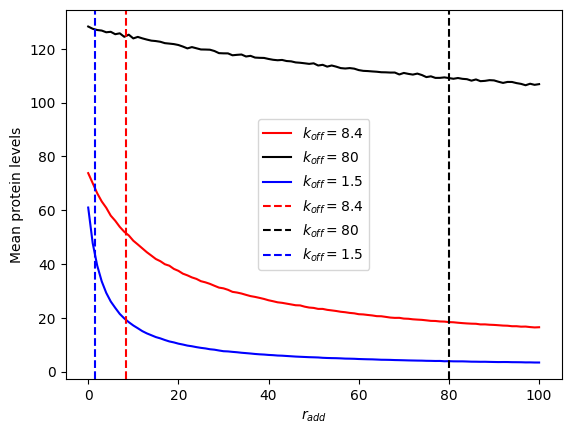

In [27]:
#Plotting mRNA levels vs r_add

plt.plot(gene_level_2_protein_kOff['r_add'], gene_level_2_protein_kOff["gene_level"], label = "$k_{off} = 8.4$", color = "red")
# plt.plot(gene_level_4_mRNA_kOff['r_add'], gene_level_4_mRNA_kOff["gene_level"],  label = "n = 4")
plt.plot(gene_level_2_max_k_off_protein['r_add'], gene_level_2_max_k_off_protein["gene_level"],  label = r"$k_{off} = 80$", color = "black")
plt.plot(gene_level_2_min_k_off_protein['r_add'], gene_level_2_min_k_off_protein["gene_level"],  label = r"$k_{off} = 1.5$", color = "blue")

plt.axvline(8.4, linestyle = "--", color = "red", label = r"$k_{off} = 8.4$")
plt.axvline(80, linestyle = "--", color = "black", label = r"$k_{off} = 80$")
plt.axvline(1.5, linestyle = "--", color = "blue", label = r"$k_{off} = 1.5$")
plt.xlabel(r"$r_{add}$")
plt.ylabel("Mean protein levels")
plt.legend()
plt.show()